## Synthetic Data and Fairness

In practice, using DCGan to generate random images is not sufficient to create a training set for training face reecognition models. We need to add some control mechanism on the models to be able to generate synthetic images representing synthetic people.

We will use here a synthetic dataset, dcface_balanced (DCFace+C_all) from this article https://arxiv.org/pdf/2412.03349.

**Copy paste the training and validation functions you used and implented in the first part in the utils subsection**

In [1]:
%%capture
!pip install pytorch_lightning
### reloaunch your environment

In [2]:
import argparse
import pytorch_lightning as pl
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import torchvision
# import umap

from tqdm.notebook import tqdm

In [3]:
### moutning google drive
from google.colab import drive
drive.mount('/content/drive')

data_folder_path = '/content/drive/My Drive/Centrale'

import os

assert os.path.exists(data_folder_path), "The specified path does not exist."

Mounted at /content/drive


### Utils

In [4]:
from torchvision import models
from torchvision.models.resnet import conv1x1, conv3x3, _resnet
from typing import Callable, Optional

import torch.nn as nn
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    """
    A wrapper for torchvision's ResNet models that outputs a 512-dimensional latent vector.
    """
    def __init__(self, model_name="r_50", normalized=True):
        """
        Initializes the ResNet model.

        Args:
            model_name (str): The name of the ResNet model to use. Options are "r_34", "r_50", "r_101".
            normalized (bool): If True, forward will retunr the vector on the unit hypersphere
        """
        super(ResNet, self).__init__()
        if model_name not in ["r_18","r_34", "r_50", "r_101"]:
            raise ValueError("Unsupported ResNet model name: {}".format(model_name))
        self.normalized = normalized
        if model_name == "r_18":
            self.backbone = models.resnet18()
        elif model_name == "r_34":
            self.backbone = models.resnet34()
        elif model_name == "r_50":
            self.backbone = _resnet(Bottleneck, [3, 4, 6, 3], None, True)
        elif model_name == "r_101":
            self.backbone = _resnet(Bottleneck, [3, 4, 23, 3], None, True)
        else:
            raise ValueError("Unsupported ResNet model name: {}".format(model_name))

        # Get the number of input features for the classifier
        # in_features = self.backbone.fc.in_features

        # Replace the final fully connected layer with a new one that outputs a 512-dim vector
        # This new layer will act as our feature embedding layer.

        if model_name == "r_34" or model_name == "r_18":
            self.backbone.fc = nn.Identity() ### somehow the nn linear below incerases the performance of the ir 18
        else:
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 512)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): The input tensor of shape (N, C, H, W).

        Returns:
            torch.Tensor: The output latent vector of shape (N, 512).
        """
        embs = self.backbone(x)
        if self.normalized:
            norm = torch.norm(embs, p=2, dim=1, keepdim=True) + 1e-6
            embs = embs.div(norm)
            return embs, norm
        return embs

In [5]:
### loading the model weights
def load_model(model_name, weights_path: str):
    model = ResNet(model_name=model_name)

    device = "cuda" if torch.cuda.is_available() else "mps"
    if device  == "cpu":
        print("WARNING: You are running on CPU, this will be slow!")
    check_dict = torch.load(weights_path,  map_location=device)
    state_dict = check_dict['state_dict']
    state_dict = {k.replace('model.', ''): v for k, v in state_dict.items() if "head" not in k}
    model.load_state_dict(state_dict)
    return model.to(device)


In [6]:
def get_alias_true_path(alias, imgs_dir):
    dir_name = "_".join(alias.split('_')[:-1])
    file_index = int(alias.split('_')[-1].split(".")[0])
    dir_content = os.listdir(os.path.join(imgs_dir, dir_name))
    true_file_name = dir_content[file_index]
    return os.path.join(imgs_dir, dir_name, true_file_name), dir_name

def image_pairs_list_to_evaluate(pair_file_path, imgs_dir="LFW/imgs"):
    with open(pair_file_path, 'r') as f:
        lines = f.readlines() # skip the first line
    path_list = []
    labels = []
    for line in tqdm(lines):
        parts = line.split(" ")
        alias_1, alias_2 = parts[0], parts[1]
        image_path1, label1 = get_alias_true_path(alias_1, imgs_dir)
        image_path2, label2 = get_alias_true_path(alias_2, imgs_dir)
        path_list.append((image_path1, image_path2))
        labels.append((label1, label2))

    return path_list, labels


In [7]:
class FVSet(torch.utils.data.Dataset):
    def __init__(self, txt_file, transform, imgs_dir="LFW/imgs", dataset_name = "LFW"):
        self.path_list, self.labels = image_pairs_list_to_evaluate(txt_file, imgs_dir=imgs_dir)
        self.transform = transform
        self.imgs_dir = imgs_dir
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self, idx):
        img_path1, img_path2 = self.path_list[idx]
        label1, label2 = self.labels[idx]

        image_1 = Image.open(img_path1)
        image_2 = Image.open(img_path2)
        image_1 = self.transform(image_1)
        image_2 = self.transform(image_2)
        return image_1, image_2, label1, label2, self.dataset_name

In [8]:
### We implement here the dataset class that loads the data


class FRSet(torch.utils.data.Dataset):
    def __init__(self, transform, imgs_dir="casia/imgs", logs=False):
        self.imgs_dir = imgs_dir
        self.transform = transform
        self.labels = []
        self.file_path_list = []
        ### list all the files
        for dir in os.listdir(imgs_dir):
            dir_path = os.path.join(imgs_dir, dir)
            if os.path.isdir(dir_path):
                for file in os.listdir(dir_path):
                    file_path = os.path.join(dir_path, file)
                    self.file_path_list.append(file_path)
                    self.labels.append(dir)
        unique_labels = np.unique(self.labels)
        label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [label_to_index[label] for label in self.labels]

    def __getitem__(self, i):

        file_name = self.file_path_list[i]
        label = self.labels[i]
        image = Image.open(file_name)
        return self.transform(image), label

    def __len__(self):
        return len(self.file_path_list)

In [9]:
def infer_fv_distances(model, data_loader):
    ## CODE HERE
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    model.eval()
    distances, issame = [], []

    with torch.no_grad():
      for img_1, img_2, lab_1, lab_2, _ in data_loader:
        emb_img_1 = model(img_1.to(device))[0]
        emb_img_2 = model(img_2.to(device))[0]
        dist_batch = torch.norm(emb_img_1 - emb_img_2, p=2, dim=1)
        distances.append(dist_batch.cpu().numpy())

        issame.extend((np.array(lab_1) == np.array(lab_2)))

    return distances, np.asarray(issame)

In [10]:
def get_accuracy_from_threshold(distances, issame, threshold):
    predictions = distances < threshold
    return np.mean(predictions == issame)


def cross_validation_computation(distance, issame, n_folds=10, logs=True):
    """
    Performs cross-validation to compute accuracy and best thresholds.
    Args:
        distance (list or np.array): List of distances between pairs.
        issame (list): List of boolean values indicating if pairs are of the same class.
        n_folds (int): Number of folds for cross-validation.
    Returns:
        tuple: Mean accuracy, standard deviation of accuracy, mean best threshold, standard deviation of best threshold.
    """
    set_seed(42)
    # shuffling distances
    indices = np.arange(len(distance))
    np.random.shuffle(indices)
    distance = distance[indices]
    issame = np.array(issame)[indices]

    fold_size = len(distance) // n_folds
    fold_accs = []
    fold_best_thresholds = []


    for i in range(n_folds):
        start = i * fold_size
        end = (i + 1) * fold_size if i < n_folds - 1 else len(distance)
        ref_distance = distance[start:end]
        ref_issame = issame[start:end]
        best_threshold = None

        ## PUT CODE HERE
        thresholds = np.arange(0, 4.0, 0.01)

        best_acc_ref = -1
        best_threshold = 0

        for t in thresholds:
            predict_issame = ref_distance < t

            acc = np.mean(predict_issame == ref_issame)

            if acc > best_acc_ref:
                best_acc_ref = acc
                best_threshold = t

        # infer fold accuracy on the non training data
        test_distance = np.concatenate((distance[:start], distance[end:]))
        test_issame = np.concatenate((issame[:start], issame[end:]))

        # Compute the true positive rate (TPR) and false positive rate (FPR)
        test_predictions = test_distance < best_threshold
        tp = np.sum(test_predictions & test_issame) # CODE HERE
        tn = np.sum((~test_predictions) & (~test_issame)) # CODE HERE
        fold_acc = (tp + tn) / len(test_issame)
        fold_accs.append(fold_acc)
        fold_best_thresholds.append(best_threshold)
    if logs:
        print("Average accuracy over folds: {:.4f} ± {:.4f}".format(np.mean(fold_accs), np.std(fold_accs)))
        print("Mean Best threshold over folds: {:.4f} ± {:.4f}".format(np.mean(fold_best_thresholds), np.std(fold_best_thresholds)))
    return np.mean(fold_accs), np.std(fold_accs), np.mean(fold_best_thresholds), np.std(fold_best_thresholds)


In [11]:
import random
import torch
from torchvision.transforms.v2 import Compose, Resize, InterpolationMode, RandomApply, RandomHorizontalFlip, RandomRotation, RandomGrayscale, ColorJitter, RandomErasing, ToImage, ToDtype, Normalize
### Write your code here
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
face_recognition_aug = Compose([
    ### CODE HERE
    Resize((112,112), antialias=True),
    # Faces are symmetric, so this is safe, it also helps the model to be robust on the faces and not on the backgrounds.
    RandomHorizontalFlip(p=0.5),
    # We want to make the model invariant to lighting conditions by changing brightness and contrast.
    # We also modify saturation, as a picture might have taken from a phone or from a webcam, with big differences in saturation.
    # Lastly we can slightly modify the hue to make the model be more robust to skin tones
    # The reason why we want to be robust to skin tones are two: Skin tone is higly variables, as it depends on lighting, seasons (people are tanned in summer),
    # makeup, camera sensors. The second reason is to make the model avoid relying on race and ethnicity.
    RandomApply([ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1)], p=0.5),
    # We want the model to be robust to imperfect alignment and head tilts. To do that we chose a very small angle, when rotating.
    RandomApply([RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR)], p=0.2),
    # As for the ColorJitter, it helps the model rely more on structural features of the face rather than the skin tone.
    RandomGrayscale(p=0.1),
    ToImage(),
    ToDtype(torch.float32, scale=True),
    Normalize(mean=mean, std=std),
    # The model should be robust to images that have faces with sunglasses or masks, this way occlusion can be simulated.
    RandomErasing(p=0.2, scale=(0.02, 0.15))
])


In [12]:
#### implent loss head
import math
def l2_norm(input,axis=1, safe_guard =False):
    norm = torch.norm(input,2,axis,True) +( ( torch.ones_like(input, requires_grad=False) * 1e-5 if safe_guard else torch.zeros_like(input, requires_grad=False)))
    output = torch.div(input, norm)
    return output

class CrossentropyHead(nn.Module):
    def __init__(self, embedding_size = 512, num_classes = 51332):
        super(CrossentropyHead, self).__init__()
        self.fc = nn.Linear(embedding_size, num_classes)

    def forward(self, embs, norms, label):
        embs = embs * norms
        return self.fc(embs)



In [13]:
def l2_norm(input,axis=1, safe_guard =False):
    norm = torch.norm(input,2,axis,True) +( ( torch.ones_like(input, requires_grad=False) * 1e-5 if safe_guard else torch.zeros_like(input, requires_grad=False)))
    output = torch.div(input, norm)
    return output

class ArcFace(nn.Module):

    def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
        super(ArcFace, self).__init__()
        self.classnum = classnum
        self.kernel = nn.Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369

        self.eps = 1e-6

    def forward(self, embbedings, norms, label):

        kernel_norm = l2_norm(self.kernel,axis=0)

        ## CODE HERE
        cosine = torch.mm(embbedings, kernel_norm)
        cosine = cosine.clamp(-1.0 + self.eps, 1.0 - self.eps)
        cosine_m = torch.cos(torch.acos(cosine) + self.m)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        final_cosines = one_hot * cosine_m + (1 - one_hot) * cosine
        scaled_cosine_m = final_cosines * self.s

        return scaled_cosine_m


In [14]:
class AdaFace(nn.Module):
    def __init__(self,
                 embedding_size=512,
                 classnum=70722,
                 m=0.4,
                 h=0.333,
                 s=64.,
                 t_alpha=0.99,
                 ):
        super(AdaFace, self).__init__()
        self.classnum = classnum
        self.kernel = nn.Parameter(torch.Tensor(embedding_size,classnum))

        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m
        self.eps = 1e-3
        self.h = h
        self.s = s

        # ema prep
        self.t_alpha = t_alpha
        self.register_buffer('t', torch.zeros(1))
        self.register_buffer('batch_mean', torch.ones(1)*(20))
        self.register_buffer('batch_std', torch.ones(1)*100)

        print('\n AdaFace with the following property')
        print('self.m', self.m)
        print('self.h', self.h)
        print('self.s', self.s)
        print('self.t_alpha', self.t_alpha)

    def forward(self, embbedings, norms, label):

        kernel_norm = l2_norm(self.kernel,axis=0)

        ## CODE HERE
        cosine = torch.mm(embbedings, kernel_norm)
        cosine = cosine.clamp(-1.0 + self.eps, 1.0 - self.eps)

        safe_norms = torch.clamp(norms, min=self.eps, max=100).clone().detach()

        if self.training:
            with torch.no_grad():
                new_batch_mean = torch.mean(safe_norms)
                new_batch_std = torch.std(safe_norms)
                self.batch_mean = self.t_alpha * self.batch_mean + (1 - self.t_alpha) * new_batch_mean
                self.batch_std = self.t_alpha * self.batch_std + (1 - self.t_alpha) * new_batch_std

        z_hat = (safe_norms - self.batch_mean)/((self.batch_std + self.eps)) * self.h
        z_hat = z_hat.clamp(-1, 1)
        z_hat = z_hat.view(-1, 1)

        g_angle = - self.m * z_hat
        g_add = self.m * z_hat + self.m
        angle = torch.acos(cosine)
        cosine_m = torch.cos(angle + g_angle) - g_add

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        final_cosines = one_hot * cosine_m + (1 - one_hot) * cosine
        scaled_cosine_m = final_cosines * self.s

        return scaled_cosine_m


In [15]:
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR

### Training Module

class ClassificationModule(pl.LightningModule):
    """
    A LightningModule for a classification task with SGD and a StepLR scheduler.

    Args:
        num_classes (int): Number of target classes.
        learning_rate (float): Base learning rate for the optimizer.
        momentum (float): Momentum factor for SGD.
        weight_decay (float): Weight decay (L2 penalty) for SGD.
    """
    def __init__(self, num_classes=10, embedding_size=512, learning_rate=0.1, momentum=0.9, weight_decay=5e-4, step_lr="12,20,24" ,head_name = "crossentropy"):
        super().__init__()
        # Save hyperparameters like learning_rate to self.hparams.
        # This makes them accessible via self.hparams and logs them automatically.
        self.save_hyperparameters()

        # Define your model
        self.model = ResNet(model_name="r_18", normalized=True)
        if head_name == "crossentropy":
            self.head = CrossentropyHead(embedding_size=embedding_size, num_classes=num_classes)
        elif head_name == "arcface":
            self.head = ArcFace(embedding_size=embedding_size, classnum=num_classes)
        elif head_name == "adaface":
            self.head = AdaFace(embedding_size=embedding_size, classnum=num_classes)
        else:
            raise NotImplementedError


        # Define the loss function
        self.criterion = nn.CrossEntropyLoss()
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        """Defines the forward pass of the model."""
        return self.model(x)


    def training_step(self, batch, batch_idx):
        """Defines the logic for a single training step."""
        images, labels = batch
        # Forward pass
        embs, norms = self.forward(images)
        logits = self.head(embs, norms, labels) ## CODE HERE

        # Calculate loss
        loss = self.criterion(logits, labels) ## CODE HERE
        with torch.no_grad():
            accuracy = (torch.argmax(logits, dim=1) == labels).float().mean() ## CODE HERE
        self.log('train_loss', loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', accuracy.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx, test_step = False):
        """
        Processes one validation batch.
        """
        with torch.no_grad():
            img1, img2, label1, label2, dataset_name = batch

            emb1, norm1 = self.forward(img1)
            emb2, norm2 = self.forward(img2)

            if self.hparams.head_name == "crossentropy":
                emb1 = emb1 * norm1
                emb2 = emb2 * norm2

            distances = torch.norm(emb1 - emb2, p=2, dim=1)

            issame_labels = torch.tensor([l1 == l2 for l1, l2 in zip(label1, label2)])
            if test_step:
                self.test_step_outputs.append( {
                    'distances': distances.cpu(),
                    'issame': issame_labels.cpu(),
                    'dataset_names': dataset_name  # Keep as a list of strings
                })
            else:
                self.validation_step_outputs.append( {
                    'distances': distances.cpu(),
                    'issame': issame_labels.cpu(),
                    'dataset_names': dataset_name  # Keep as a list of strings
                })
    def on_validation_epoch_end(self):
        """
        Called at the end of the validation epoch.

        Args:
            outputs (list): A list of dictionaries, where each dict is
                            the return value from validation_step.
        """
        print("\n[Validation Epoch End] Aggregating results...")
        outputs = self.validation_step_outputs
        with torch.no_grad():
            aggregated_data = {}

            for batch_output in outputs:
                for dist, issame, name in zip(batch_output['distances'],
                                            batch_output['issame'],
                                            batch_output['dataset_names']):
                    if name not in aggregated_data:
                        aggregated_data[name] = {'distances': [], 'issame': []}
                    aggregated_data[name]['distances'].append(dist.item())
                    aggregated_data[name]['issame'].append(issame.item())

            print(f"Found {len(aggregated_data)} datasets: {list(aggregated_data.keys())}")

            for dataset_name, data in aggregated_data.items():
                distances = data['distances']
                issame = data['issame']

                distances = np.asarray(distances)
                issame = np.asarray(issame)

                print(f"Running CV for {dataset_name}...")

                mean_acc, std_acc, mean_thresh, std_thresh = cross_validation_computation(
                    distance=distances,
                    issame=issame,
                    n_folds=10
                )

                self.log(f'val_acc/{dataset_name}', mean_acc, sync_dist=True)
                self.log(f'val_thresh/{dataset_name}', mean_thresh, sync_dist=True)
                self.log(f'val_acc_std/{dataset_name}', std_acc, sync_dist=True)
                self.log(f'val_thresh_std/{dataset_name}', std_thresh, sync_dist=True)

                print(f"  [Result] {dataset_name}: Acc={mean_acc:.4f} (±{std_acc:.4f}), Thresh={mean_thresh:.4f}")

        self.validation_step_outputs.clear()

        print("[Validation Epoch End] Finished.\n")

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, test_step=True)
    def on_test_epoch_end(self):
        with torch.no_grad():
            outputs = self.test_step_outputs
            aggregated_data = {}

            for batch_output in outputs:
                for dist, issame, name in zip(batch_output['distances'],
                                            batch_output['issame'],
                                            batch_output['dataset_names']):
                    if name not in aggregated_data:
                        aggregated_data[name] = {'distances': [], 'issame': []}
                    aggregated_data[name]['distances'].append(dist.item())
                    aggregated_data[name]['issame'].append(issame.item())

            print(f"Found {len(aggregated_data)} datasets: {list(aggregated_data.keys())}")

            for dataset_name, data in aggregated_data.items():
                distances = data['distances']
                issame = data['issame']

                print(f"Running CV for {dataset_name}...")

                mean_acc, std_acc, mean_thresh, std_thresh = cross_validation_computation(
                    distance=distances,
                    issame=issame,
                    n_folds=10
                )

                self.log(f'test_acc/{dataset_name}', mean_acc, sync_dist=True)
                self.log(f'test_thresh/{dataset_name}', mean_thresh, sync_dist=True)
                self.log(f'test_acc_std/{dataset_name}', std_acc, sync_dist=True)
                self.log(f'test_thresh_std/{dataset_name}', std_thresh, sync_dist=True)

                print(f"  [Result] {dataset_name}: Acc={mean_acc:.4f} (±{std_acc:.4f}), Thresh={mean_thresh:.4f}")

        self.test_step_outputs.clear()

    def configure_optimizers(self):
        """
        Configures the optimizer (SGD) and learning rate scheduler (MultiStepLR).
        """

        ## CODE HERE
        optimizer = SGD(params=self.parameters(), lr=self.hparams.learning_rate, momentum=self.hparams.momentum, weight_decay=self.hparams.weight_decay)
        milestones = [int(x.strip()) for x in self.hparams.step_lr.split(',')]
        scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
            }
        }


In [16]:
def set_seed(seed: int):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [17]:
class FRDataModule(pl.LightningDataModule):
    def __init__(self, imgs_dir, batch_size=128, num_workers=4, eval_path="LFW/imgs", txt_eval_file="LFW/pairs.txt", eval_dataset_name="LFW"):
        """
        Initializes the data module.
        """
        super().__init__()
        self.imgs_dir = imgs_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.eval_path = eval_path
        self.txt_eval_file = txt_eval_file
        self.eval_dataset_name = eval_dataset_name

        # self.transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Resize((112,112), antialias=True),
        #     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        # ])

    def setup(self, stage=None):
        """Sets up the datasets for training and validation."""
        if stage == 'fit' or stage is None:
            self.train_dataset = FRSet(transform=face_recognition_aug, imgs_dir=self.imgs_dir)
            self.val_dataset = FVSet(txt_file=self.txt_eval_file, transform=image_transform, imgs_dir=self.eval_path, dataset_name=self.eval_dataset_name)

    def train_dataloader(self):
        """Returns the training dataloader."""
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )
    def val_dataloader(self):
        """Returns the validation dataloader."""

        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers
        )

In [18]:
from torchvision.transforms.v2 import Compose, Resize, ToImage, ToDtype, Normalize

image_transform = Compose([
        ToImage(),
        ToDtype(torch.float32, scale=True),
        Resize((112,112), antialias=True),
        Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [19]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
# Assuming your ClassificationModule and FRDataModule are defined as before

# Configure the callback to save every epoch
checkpoint_callback = ModelCheckpoint(
    every_n_epochs=1,
    save_top_k=-1
)

In [20]:
## Copying evaluation set and model weights
!cp -r "/content/drive/MyDrive/Centrale/LFW" .
! cd LFW && tar -xf imgs.tar

## training on sythetic data

**[Question 1]** Run your training script on the dcface_balanced dataset and check the corresponding validation scores on LFW. Compare them with the one obtained on the real data.


In [ ]:
## RUN ONCE
!mkdir -p dcface_balanced && cp /content/drive/MyDrive/Centrale/dcface-balanced/imgs.tar dcface_balanced/ && cd dcface_balanced && tar -xf imgs.tar

In [21]:
from pytorch_lightning.callbacks import TQDMProgressBar
set_seed(42)
head_name = "adaface"
csv_logger = CSVLogger(save_dir="logs2/",
                       name=head_name
)

# Initialize the data module
data_module = FRDataModule(
    imgs_dir="dcface_balanced/imgs",
    batch_size=512,
    num_workers=11,
    eval_path="LFW/imgs",
    txt_eval_file="LFW/pairs.txt",
    eval_dataset_name="LFW"
)

# Initialize the model
model = ClassificationModule(
    num_classes=10000,  # Adjust based on your dataset
    embedding_size=512,
    learning_rate=0.1,
    momentum=0.9,
    weight_decay=5e-4,
    step_lr="12,20,24",
    head_name=head_name
)


# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=30,
    logger=csv_logger,
    #gpus=1 if torch.cuda.is_available() else 0,
    precision=32 if torch.cuda.is_available() else 32,
    callbacks=[checkpoint_callback, TQDMProgressBar()],
    fast_dev_run=False # Set to True for a quick test run; set to False for full training

)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores



 AdaFace with the following property
self.m 0.4
self.h 0.333
self.s 64.0
self.t_alpha 0.99


In [ ]:
### training the model
# Set random seed for reproducibility
from pytorch_lightning.callbacks import TQDMProgressBar
from my_dataset import FRDataModule
set_seed(42)
head_name = "adaface"
csv_logger = CSVLogger(save_dir="logs2/",
                       name=head_name
)

# Initialize the data module
data_module = FRDataModule(
    imgs_dir="dcface_balanced/imgs",
    batch_size=512,
    num_workers=11,
    eval_path="LFW/imgs",
    txt_eval_file="LFW/pairs.txt",
    eval_dataset_name="LFW"
)

# Initialize the model
model = ClassificationModule(
    num_classes=10000,  # Adjust based on your dataset
    embedding_size=512,
    learning_rate=0.1,
    momentum=0.9,
    weight_decay=5e-4,
    step_lr="12,20,24",
    head_name=head_name
)


# Initialize the trainer
trainer = pl.Trainer(
    max_epochs=30,
    logger=csv_logger,
    #gpus=1 if torch.cuda.is_available() else 0,
    precision=32 if torch.cuda.is_available() else 32,
    callbacks=[checkpoint_callback, TQDMProgressBar()],
    fast_dev_run=False # Set to True for a quick test run; set to False for full training

)

# Train the model
trainer.fit(model, datamodule=data_module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores



 AdaFace with the following property
self.m 0.4
self.h 0.333
self.s 64.0
self.t_alpha 0.99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 17013.50it/s]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet           │ 11.2 M │ train │     0 │
│ 1 │ head      │ AdaFace          │  5.1 M │ train │     0 │
│ 2 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 16.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 16.3 M                                                                                               
Total estimated model params size (MB): 65                                                                         
Modules in train mode: 71                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |                                                                                            …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.5742 ± 0.0334
Mean Best threshold over folds: 0.1390 ± 0.0230
  [Result] LFW: Acc=0.5742 (±0.0334), Thresh=0.1390
[Validation Epoch End] Finished.



Training: |                                                                                                   …

Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.6386 ± 0.0116
Mean Best threshold over folds: 0.7080 ± 0.0567
  [Result] LFW: Acc=0.6386 (±0.0116), Thresh=0.7080
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.7596 ± 0.0127
Mean Best threshold over folds: 1.0070 ± 0.0344
  [Result] LFW: Acc=0.7596 (±0.0127), Thresh=1.0070
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8095 ± 0.0036
Mean Best threshold over folds: 1.0710 ± 0.0243
  [Result] LFW: Acc=0.8095 (±0.0036), Thresh=1.0710
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8254 ± 0.0038
Mean Best threshold over folds: 1.1400 ± 0.0155
  [Result] LFW: Acc=0.8254 (±0.0038), Thresh=1.1400
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8691 ± 0.0035
Mean Best threshold over folds: 1.1550 ± 0.0196
  [Result] LFW: Acc=0.8691 (±0.0035), Thresh=1.1550
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8587 ± 0.0025
Mean Best threshold over folds: 1.1500 ± 0.0134
  [Result] LFW: Acc=0.8587 (±0.0025), Thresh=1.1500
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8725 ± 0.0030
Mean Best threshold over folds: 1.1510 ± 0.0130
  [Result] LFW: Acc=0.8725 (±0.0030), Thresh=1.1510
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8528 ± 0.0026
Mean Best threshold over folds: 1.1590 ± 0.0181
  [Result] LFW: Acc=0.8528 (±0.0026), Thresh=1.1590
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8478 ± 0.0024
Mean Best threshold over folds: 1.1740 ± 0.0191
  [Result] LFW: Acc=0.8478 (±0.0024), Thresh=1.1740
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8523 ± 0.0038
Mean Best threshold over folds: 1.1670 ± 0.0173
  [Result] LFW: Acc=0.8523 (±0.0038), Thresh=1.1670
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8699 ± 0.0042
Mean Best threshold over folds: 1.1810 ± 0.0176
  [Result] LFW: Acc=0.8699 (±0.0042), Thresh=1.1810
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8418 ± 0.0019
Mean Best threshold over folds: 1.1790 ± 0.0094
  [Result] LFW: Acc=0.8418 (±0.0019), Thresh=1.1790
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8799 ± 0.0040
Mean Best threshold over folds: 1.2100 ± 0.0179
  [Result] LFW: Acc=0.8799 (±0.0040), Thresh=1.2100
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8909 ± 0.0036
Mean Best threshold over folds: 1.2130 ± 0.0162
  [Result] LFW: Acc=0.8909 (±0.0036), Thresh=1.2130
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8866 ± 0.0041
Mean Best threshold over folds: 1.2180 ± 0.0117
  [Result] LFW: Acc=0.8866 (±0.0041), Thresh=1.2180
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8924 ± 0.0034
Mean Best threshold over folds: 1.2170 ± 0.0078
  [Result] LFW: Acc=0.8924 (±0.0034), Thresh=1.2170
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8837 ± 0.0037
Mean Best threshold over folds: 1.2390 ± 0.0122
  [Result] LFW: Acc=0.8837 (±0.0037), Thresh=1.2390
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8617 ± 0.0027
Mean Best threshold over folds: 1.2240 ± 0.0174
  [Result] LFW: Acc=0.8617 (±0.0027), Thresh=1.2240
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8798 ± 0.0050
Mean Best threshold over folds: 1.2440 ± 0.0143
  [Result] LFW: Acc=0.8798 (±0.0050), Thresh=1.2440
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8507 ± 0.0055
Mean Best threshold over folds: 1.2380 ± 0.0172
  [Result] LFW: Acc=0.8507 (±0.0055), Thresh=1.2380
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8573 ± 0.0057
Mean Best threshold over folds: 1.2470 ± 0.0168
  [Result] LFW: Acc=0.8573 (±0.0057), Thresh=1.2470
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8711 ± 0.0027
Mean Best threshold over folds: 1.2510 ± 0.0094
  [Result] LFW: Acc=0.8711 (±0.0027), Thresh=1.2510
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8729 ± 0.0040
Mean Best threshold over folds: 1.2570 ± 0.0090
  [Result] LFW: Acc=0.8729 (±0.0040), Thresh=1.2570
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8678 ± 0.0052
Mean Best threshold over folds: 1.2500 ± 0.0161
  [Result] LFW: Acc=0.8678 (±0.0052), Thresh=1.2500
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8666 ± 0.0040
Mean Best threshold over folds: 1.2510 ± 0.0130
  [Result] LFW: Acc=0.8666 (±0.0040), Thresh=1.2510
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8665 ± 0.0036
Mean Best threshold over folds: 1.2580 ± 0.0125
  [Result] LFW: Acc=0.8665 (±0.0036), Thresh=1.2580
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8683 ± 0.0017
Mean Best threshold over folds: 1.2580 ± 0.0125
  [Result] LFW: Acc=0.8683 (±0.0017), Thresh=1.2580
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8680 ± 0.0037
Mean Best threshold over folds: 1.2520 ± 0.0125
  [Result] LFW: Acc=0.8680 (±0.0037), Thresh=1.2520
[Validation Epoch End] Finished.



Validation: |                                                                                                 …


[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8672 ± 0.0035
Mean Best threshold over folds: 1.2530 ± 0.0127
  [Result] LFW: Acc=0.8672 (±0.0035), Thresh=1.2530
[Validation Epoch End] Finished.



Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.



[Validation Epoch End] Aggregating results...
Found 1 datasets: ['LFW']
Running CV for LFW...
Average accuracy over folds: 0.8652 ± 0.0033
Mean Best threshold over folds: 1.2540 ± 0.0136
  [Result] LFW: Acc=0.8652 (±0.0033), Thresh=1.2540
[Validation Epoch End] Finished.



In [ ]:
from google.colab import files
files.download("/content/logs/adaface/version_0/checkpoints/epoch=29-step=29310.ckpt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
#model.load_state_dict(torch.load("./epoch=29-step=29310.ckpt")["state_dict"])
model.load_state_dict(
    torch.load("./epoch=29-step=29310.ckpt", map_location=torch.device('cpu'))["state_dict"]
)

<All keys matched successfully>

## RFW

As you can see on the validation results, the accuracy is quite high on the LFW benchmark sets. Works have thus improved the validation process by introducing harder benchmark FV sets that often introduce a variability in the data with regard to a potential sensitive attribute. This is the case for the RFW dataset which introduces variability with regard to race (Caucasian, African, Indian, Asian). We will check here how sensitive (fair) the models are with regard to this attribute.

In [42]:
_ = model.cuda().eval()

In [43]:
## Copying evaluation set and model weights
!cp -r "/content/drive/MyDrive/Centrale/RFW" .
! cd RFW && tar -xf aligned_imgs.tar

In [44]:
fvSet = FVSet(txt_file="RFW/pairs.txt", transform=image_transform, imgs_dir="RFW/aligned_imgs")
fvLoader = torch.utils.data.DataLoader(fvSet, batch_size=128, shuffle=False, num_workers=0)

  0%|          | 0/24000 [00:00<?, ?it/s]

In [46]:
casia_model = ClassificationModule(num_classes=10572, embedding_size=512, learning_rate=0.1, momentum=0.9, weight_decay=5e-4, step_lr="12,20,24", head_name="adaface")
casia_model.load_state_dict(torch.load("epoch=29-step=28770.ckpt", map_location=torch.device('cpu'))["state_dict"])
_ = casia_model.cuda().eval()


 AdaFace with the following property
self.m 0.4
self.h 0.333
self.s 64.0
self.t_alpha 0.99


In [47]:
distances, issame = infer_fv_distances(model, fvLoader)
_ = cross_validation_computation(np.concatenate(distances), issame, n_folds=10)

Average accuracy over folds: 0.6619 ± 0.0014
Mean Best threshold over folds: 1.2580 ± 0.0108


In [48]:
distances, issame = infer_fv_distances(casia_model, fvLoader)
_ = cross_validation_computation(np.concatenate(distances), issame, n_folds=10)

Average accuracy over folds: 0.7198 ± 0.0014
Mean Best threshold over folds: 1.1570 ± 0.0127


**[Question 2]** Compare the results you obtain on RFW with the one obtained on LFW. What intuition do you have about the difference in accuracy between these two evaluation modalities?

In [49]:
class ImageDataset(torch.utils.data.Dataset):
    # to complete
    def __init__(self, images_dir_path, transform=None):
        self.image_paths = []
        for dir in os.listdir(images_dir_path):
            if os.path.isdir(os.path.join(images_dir_path, dir)):
                for file in os.listdir(os.path.join(images_dir_path, dir)):
                    self.image_paths.append(os.path.join(images_dir_path, dir, file))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB") # Ensure image is in RGB format
        if self.transform:
            image = self.transform(image)
        return image, img_path
image_set = ImageDataset(images_dir_path="RFW/aligned_imgs", transform=image_transform)
data_loader = torch.utils.data.DataLoader(image_set, batch_size=128, shuffle=False, num_workers=0)


**[Question 3]**: Extract the features of each image from RFW and store their corresponding race, using the models trained with ADFACE on bot CASIA and dcface-balanced

In [70]:
### CODE HERE
def extract_features_and_races(model_dc, model_casia, loader):
    device = "cuda" if torch.cuda.is_available() else "mps"

    feats_dc_list = []
    feats_casia_list = []
    race_labels_list = []

    with torch.no_grad():
        for images, paths in tqdm(loader, desc="Processing Batches"):
            images = images.to(device)

            emb_dc, _ = model_dc(images)
            feats_dc_list.append(emb_dc.cpu())

            emb_casia, _ = model_casia(images)
            feats_casia_list.append(emb_casia.cpu())

            for path in paths:
                if "African" in path:
                    race = "African"
                elif "Asian" in path:
                    race = "Asian"
                elif "Caucasian" in path:
                    race = "Caucasian"
                elif "Indian" in path:
                    race = "Indian"
                else:
                    race = "Unknown"

                race_labels_list.append(race)

    features_dc = torch.cat(feats_dc_list, dim=0).numpy()
    features_casia = torch.cat(feats_casia_list, dim=0).numpy()
    race_labels = np.array(race_labels_list)

    return features_dc, features_casia, race_labels

features_dc, features_casia, race_labels = extract_features_and_races(model, casia_model, data_loader)

Processing Batches: 100%|██████████| 318/318 [00:58<00:00,  5.40it/s]


In [66]:
import numpy as np

np.savez_compressed('rfw_features.npz',
                    features_dc=features_dc,
                    features_casia=features_casia,
                    race_labels=race_labels)

print("Features and labels saved to 'rfw_features.npz'")

Features and labels saved to 'rfw_features.npz'


In [ ]:
import numpy as np

data = np.load('rfw_features.npz')

features_dc = data['features_dc']
features_casia = data['features_casia']
race_labels = data['race_labels']

print("Data loaded successfully.")
print(f"DC Features shape: {features_dc.shape}")
print(f"CASIA Features shape: {features_casia.shape}")
print(f"Race Labels shape: {race_labels.shape}")

In [71]:
features = features_casia
races = race_labels

In [39]:
!pip install umap-learn

**[Question 4]**: Do you think we can in theory use PCA (principal component analysis) in order to visualize the features from a model that has been trained with ArcFace or AdaFace? Why? What about T-SNE or UMAP ?

We will here use UMAP




**[Question 5]** :Explain in your own words how UMAP is performing data projection. Apply it on the RFW images features to project them in 2D and plot them with a different color for the race attributes. Can you draw any conclusions on how sensitive to the attributes the models are?




In [72]:
import umap
reducer = umap.UMAP()
projected_embeddings = reducer.fit_transform(features)

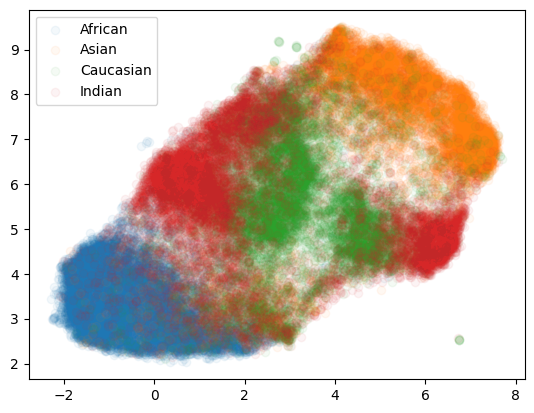

In [73]:
for label in np.unique(races):
    plt.scatter(projected_embeddings[races == label, 0], projected_embeddings[races== label, 1], label = label, alpha=0.05)
leg  =plt.legend()

**[Question 6 optional]**Try to visualize the data using different projection approaches.

> Add blockquote



Running PCA for DCFace (Balanced)...
Running Kernel PCA for DCFace (Balanced)...
Running t-SNE for DCFace (Balanced)...


AttributeError: 'Legend' object has no attribute 'legendHandles'

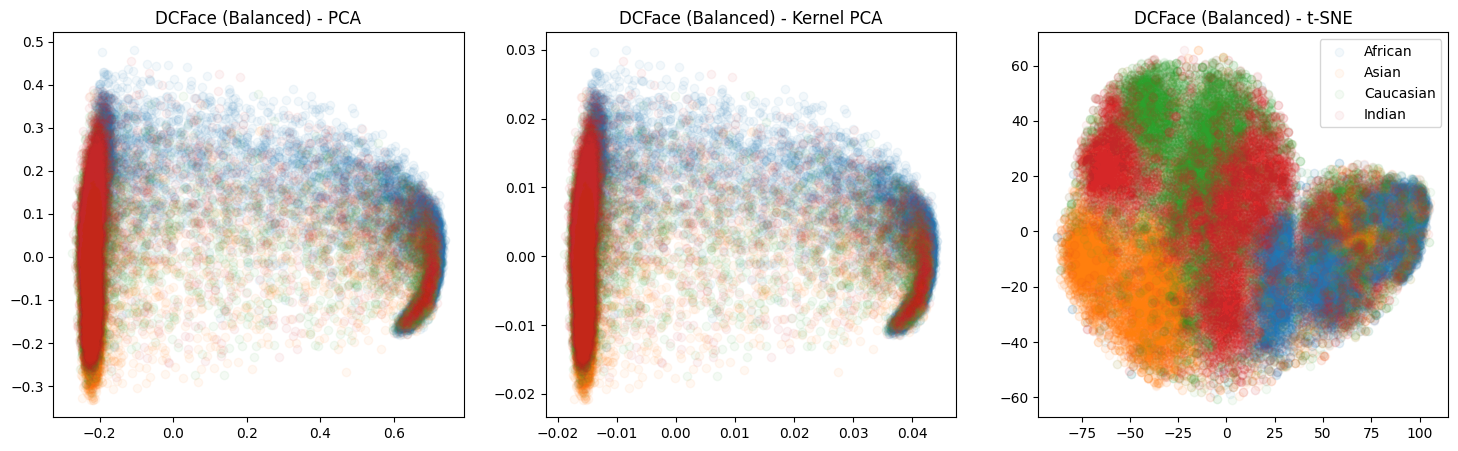

In [75]:
### CODE HERE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
reducers = {
    "PCA": PCA(n_components=2),
    # Kernel PCA with RBF kernel captures non-linear structures
    "Kernel PCA": KernelPCA(n_components=2, kernel="rbf", fit_inverse_transform=False),
    # t-SNE with PCA initialization for better stability
    "t-SNE": TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=30)
}

def plot_projections(features, races, model_name):
    plt.figure(figsize=(18, 5))

    for i, (method_name, reducer) in enumerate(reducers.items()):
        plt.subplot(1, 3, i + 1)

        # Projection step
        print(f"Running {method_name} for {model_name}...")
        projected_embeddings = reducer.fit_transform(features)

        # Plotting loop (Following your requested structure)
        for label in np.unique(races):
            plt.scatter(
                projected_embeddings[races == label, 0],
                projected_embeddings[races == label, 1],
                label=label,
                alpha=0.05  # High transparency to visualize density
            )

        # visual styling
        plt.title(f"{model_name} - {method_name}")
        # We add a legend only to the last plot to avoid clutter, with opaque markers
        if i == 2:
            leg = plt.legend(loc='best')
            for lh in leg.legendHandles:
                lh.set_alpha(1) # Make legend markers visible

    plt.tight_layout()
    plt.show()


plot_projections(features_dc, races, "DCFace (Balanced)")

We will now analayse in a finer way the performances of the model, that is the fairness with regard to the ethnicity.

**[Question 7]** Write a function that computes an optimal threshold on th RFW dataset (no need to perform crossvalidation here) and then extract for each race the associated accuracy. Apply the function on the model trained on casia and the one trained on dcface, what can you conclude ?

In [ ]:
### CODE HERE

**[Question 8]** Try to find your own a metric that quantify how biased a model is with regard to the ethnicity. Conclude

In [ ]:
### Code HERE

**[Question 9]** Write a formal conclusion recapitulating the insights this practical give you on the face recognition task. Write it in an academical way (i.e. in a similar way as the conclusions you can find within the articles mentioned through this practical)
